# HAR-SKPR: Демонстрація методу СКПР для розпізнавання активності

Цей notebook демонструє базове використання методу статистичного розпізнавання образів у просторі з порідним елементом (СКПР) для задачі розпізнавання активності людини.

## 1. Імпорт необхідних модулів

In [1]:
import sys
import os
sys.path.append('..')  # Додаємо шлях до кореневої директорії проекту

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Імпорт модулів проекту
from src.data_loader import load_raw_signals_and_labels, get_activity_names, get_dataset_info
from src.preprocessing import StandardScaler3D
from src.feature_extractors import OptimalFeatureExtractor
from src.utils import plot_confusion_matrix

# Налаштування візуалізації
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Завантаження та огляд даних

In [2]:
# Завантажуємо інформацію про датасет
dataset_info = get_dataset_info()

print("Інформація про датасет UCI HAR:")
print("=" * 50)
for key, value in dataset_info.items():
    if key not in ['activity_names', 'channel_names']:
        print(f"{key}: {value}")

Інформація про датасет UCI HAR:
n_train_samples: 7352
n_test_samples: 2947
n_timepoints: 128
n_channels: 9
n_classes: 6
sampling_rate: 50
window_size: 2.56
window_overlap: 0.5


In [3]:
# Завантажуємо дані
print("Завантаження даних...")
X_train, y_train = load_raw_signals_and_labels("train")
X_test, y_test = load_raw_signals_and_labels("test")

print(f"\nРозміри даних:")
print(f"Тренувальна вибірка: {X_train.shape}")
print(f"Тестова вибірка: {X_test.shape}")

# Отримуємо назви активностей
activity_map = get_activity_names()

Завантаження даних...

Розміри даних:
Тренувальна вибірка: (7352, 128, 9)
Тестова вибірка: (2947, 128, 9)


## 3. Візуалізація прикладів сигналів

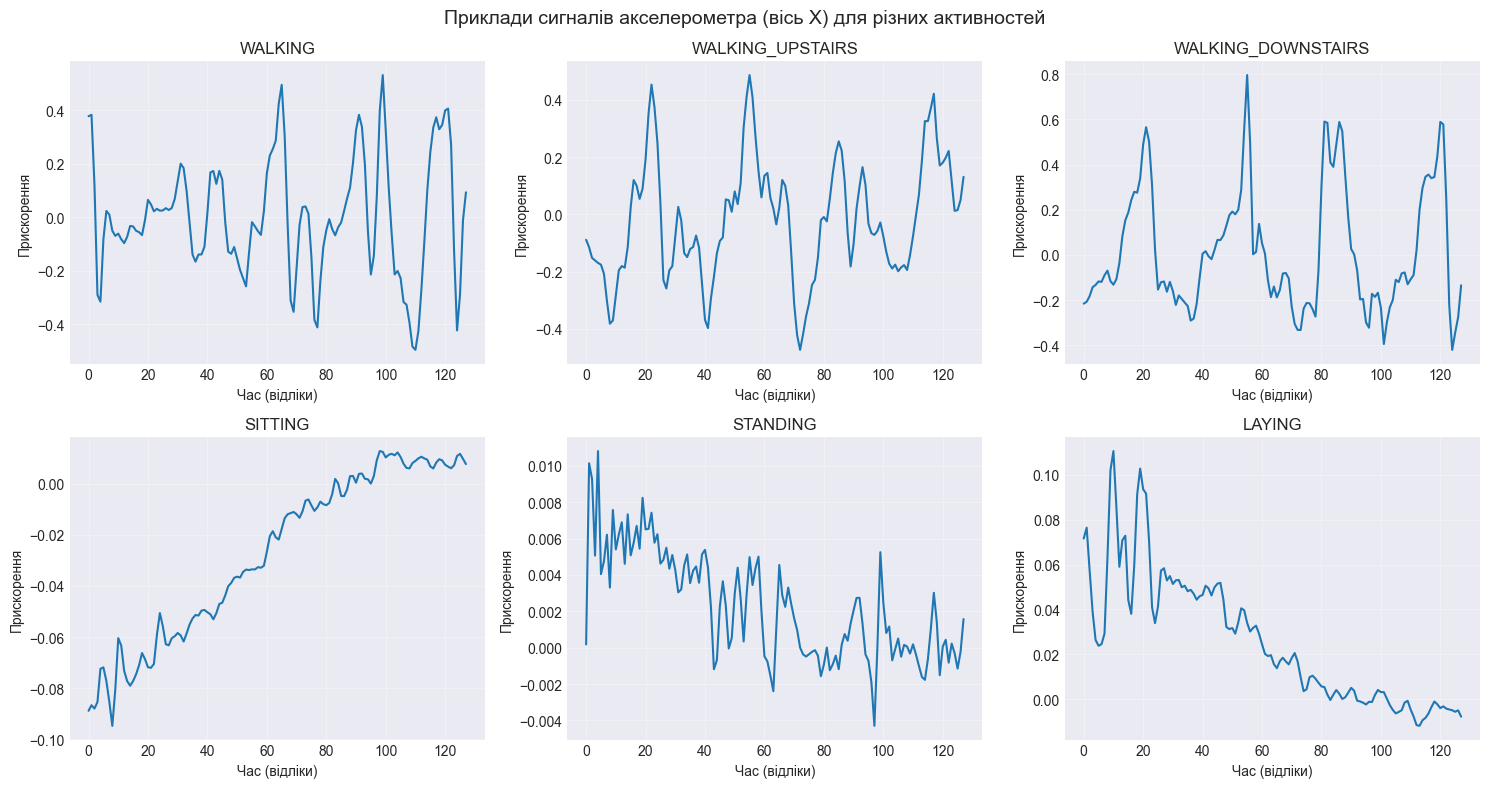

In [4]:
# Візуалізуємо приклади сигналів для різних активностей
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (class_idx, class_name) in enumerate(activity_map.items()):
    # Знаходимо перший зразок цього класу
    sample_idx = np.where(y_train == class_idx)[0][0]
    
    # Візуалізуємо акселерометр по осі X
    signal = X_train[sample_idx, :, 0]  # body_acc_x
    
    axes[i].plot(signal, linewidth=1.5)
    axes[i].set_title(f'{class_name}', fontsize=12)
    axes[i].set_xlabel('Час (відліки)')
    axes[i].set_ylabel('Прискорення')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Приклади сигналів акселерометра (вісь X) для різних активностей', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Застосування методу СКПР

In [5]:
# Крок 1: Стандартизація даних
print("Крок 1: Стандартизація 3D сигналів...")
scaler_3d = StandardScaler3D()
X_train_scaled = scaler_3d.fit_transform(X_train)
X_test_scaled = scaler_3d.transform(X_test)
print("✓ Готово")

Крок 1: Стандартизація 3D сигналів...
✓ Готово


In [6]:
# Крок 2: Генерація ознак СКПР
print("Крок 2: Генерація ознак методом СКПР...")
print("Використовується оптимальний дробово-степеневий базис:")
print("  φ₁(x) = sign(x)·√|x|")
print("  φ₂(x) = sign(x)·∛|x|")

feature_extractor = OptimalFeatureExtractor()

# Навчання моделей реконструкції
print("\nНавчання моделей реконструкції для кожного класу...")
feature_extractor.fit(X_train_scaled, y_train)

# Генерація ознак
X_train_features = feature_extractor.transform(X_train_scaled)
X_test_features = feature_extractor.transform(X_test_scaled)

print(f"\n✓ Згенеровано {X_train_features.shape[1]} ознак")
print(f"Кожна ознака = log(похибка реконструкції для відповідного класу)")

Крок 2: Генерація ознак методом СКПР...
Використовується оптимальний дробово-степеневий базис:
  φ₁(x) = sign(x)·√|x|
  φ₂(x) = sign(x)·∛|x|

Навчання моделей реконструкції для кожного класу...

✓ Згенеровано 6 ознак
Кожна ознака = log(похибка реконструкції для відповідного класу)


## 5. Візуалізація згенерованих ознак

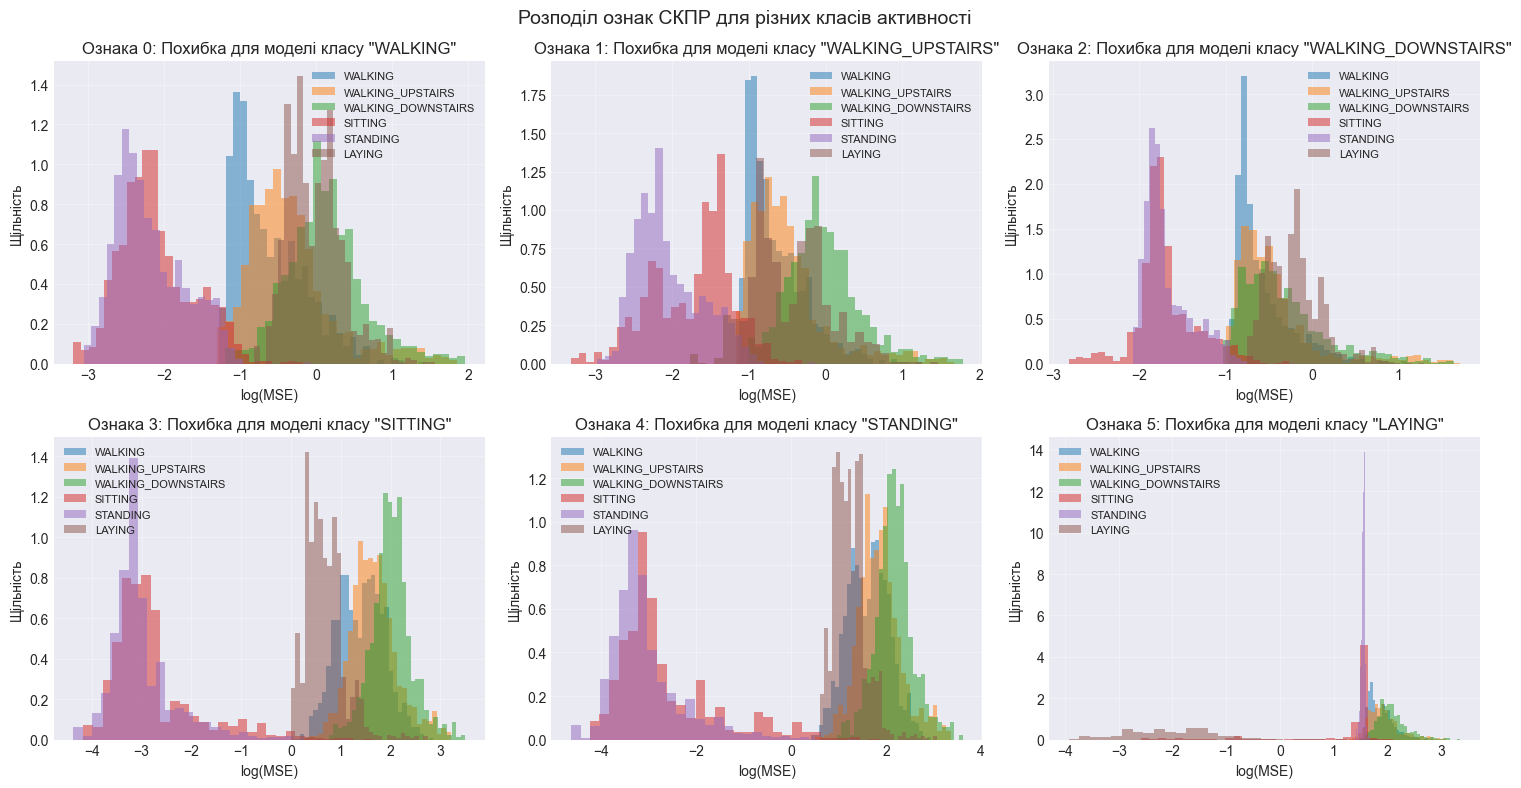

In [7]:
# Візуалізація розподілу ознак для різних класів
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for feature_idx in range(6):
    ax = axes[feature_idx]
    
    # Для кожного класу візуалізуємо розподіл відповідної ознаки
    for class_idx, class_name in activity_map.items():
        mask = y_train == class_idx
        values = X_train_features[mask, feature_idx]
        
        ax.hist(values, bins=30, alpha=0.5, label=class_name, density=True)
    
    ax.set_title(f'Ознака {feature_idx}: Похибка для моделі класу "{list(activity_map.values())[feature_idx]}"')
    ax.set_xlabel('log(MSE)')
    ax.set_ylabel('Щільність')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Розподіл ознак СКПР для різних класів активності', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Класифікація

In [8]:
# Крок 3: Стандартизація ознак
print("Крок 3: Стандартизація згенерованих ознак...")
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_features)
X_test_final = scaler.transform(X_test_features)
print("✓ Готово")

Крок 3: Стандартизація згенерованих ознак...
✓ Готово


In [9]:
# Крок 4: Навчання SVM
print("Крок 4: Навчання SVM класифікатора...")
classifier = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)
classifier.fit(X_train_final, y_train)
print("✓ Готово")

Крок 4: Навчання SVM класифікатора...
✓ Готово


In [10]:
# Крок 5: Оцінка продуктивності
print("Крок 5: Оцінка на тестовій вибірці...")
y_pred = classifier.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n{'='*50}")
print(f"РЕЗУЛЬТАТ: Точність = {accuracy:.4f}")
print(f"{'='*50}")

Крок 5: Оцінка на тестовій вибірці...

РЕЗУЛЬТАТ: Точність = 0.8459


## 7. Детальний аналіз результатів

In [11]:
# Детальний звіт класифікації
print("Детальний звіт по класах:")
print(classification_report(y_test, y_pred, target_names=activity_map.values()))

Детальний звіт по класах:
                    precision    recall  f1-score   support

           WALKING       0.73      0.86      0.79       496
  WALKING_UPSTAIRS       0.89      0.70      0.78       471
WALKING_DOWNSTAIRS       0.86      0.90      0.88       420
           SITTING       0.90      0.68      0.77       491
          STANDING       0.76      0.92      0.84       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.85      2947
         macro avg       0.86      0.84      0.84      2947
      weighted avg       0.86      0.85      0.84      2947



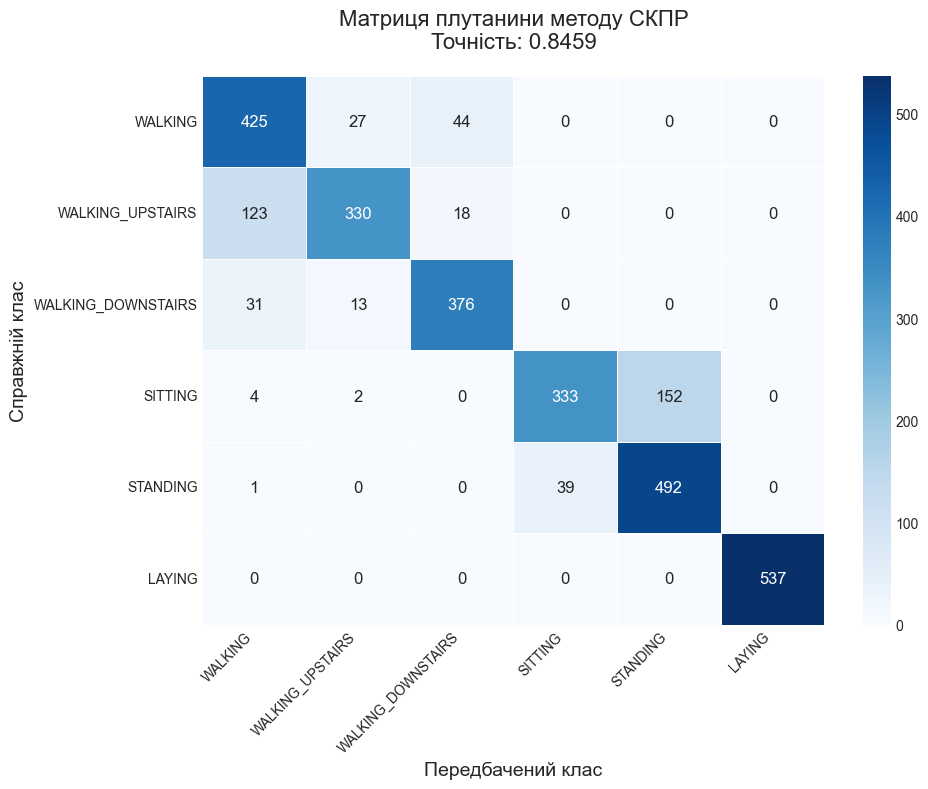

In [12]:
# Матриця плутанини
cm = plot_confusion_matrix(
    y_test, y_pred,
    class_names=list(activity_map.values()),
    title=f'Матриця плутанини методу СКПР\nТочність: {accuracy:.4f}',
    figsize=(10, 8)
)
plt.show()

## 8. Висновки

Метод СКПР продемонстрував високу ефективність для задачі розпізнавання активності людини:

1. **Компактність**: Використовуючи лише 6 ознак (по одній для кожного класу), метод досягає високої точності класифікації.

2. **Інтерпретованість**: Кожна ознака має чітку інтерпретацію - це міра "несхожості" сигналу на відповідний клас активності.

3. **Ефективність**: Метод не потребує складних обчислень і може працювати в реальному часі.

4. **Основні труднощі**: Найбільші проблеми виникають при розрізненні статичних поз (SITTING/STANDING), що є типовою проблемою для інерційних сенсорів.

## Додаток: Візуалізація базисних функцій

/var/folders/0s/qqf1r0f11gd0r6zkbswkqgn40000gn/T/ipykernel_47143/4087578660.py:25: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/0s/qqf1r0f11gd0r6zkbswkqgn40000gn/T/ipykernel_47143/4087578660.py:25: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/0s/qqf1r0f11gd0r6zkbswkqgn40000gn/T/ipykernel_47143/4087578660.py:25: UserWarning: Glyph 8731 (\N{CUBE ROOT}) missing from font(s) Arial.
  plt.tight_layout()
/Users/serhiizabolotnii/Projects/SKPR_HAR/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/serhiizabolotnii/Projects/SKPR_HAR/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/serhiizabolotnii/Projects

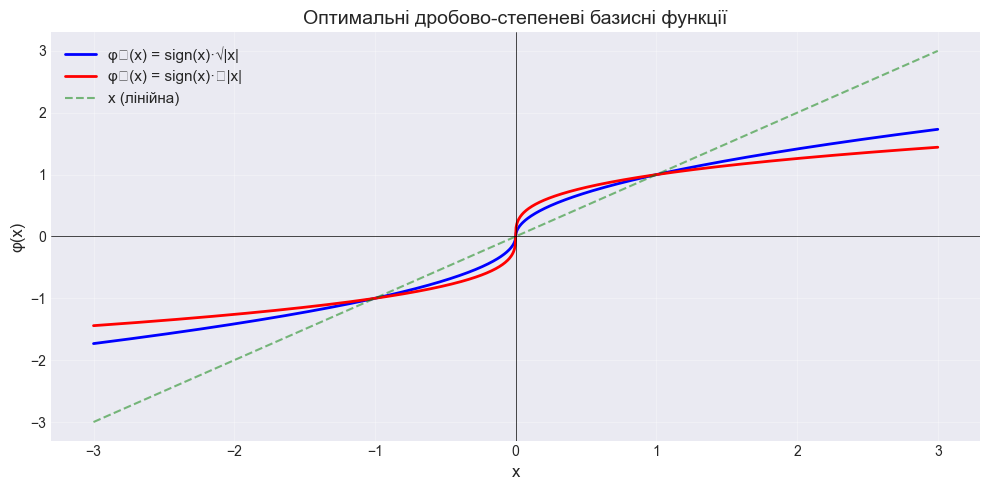

In [13]:
# Візуалізація оптимальних базисних функцій
x = np.linspace(-3, 3, 1000)

plt.figure(figsize=(10, 5))

# φ₁(x) = sign(x)·√|x|
y1 = np.sign(x) * np.sqrt(np.abs(x))
plt.plot(x, y1, 'b-', linewidth=2, label='φ₁(x) = sign(x)·√|x|')

# φ₂(x) = sign(x)·∛|x|
y2 = np.sign(x) * np.cbrt(np.abs(x))
plt.plot(x, y2, 'r-', linewidth=2, label='φ₂(x) = sign(x)·∛|x|')

# Для порівняння - лінійна функція
plt.plot(x, x, 'g--', alpha=0.5, label='x (лінійна)')

plt.xlabel('x', fontsize=12)
plt.ylabel('φ(x)', fontsize=12)
plt.title('Оптимальні дробово-степеневі базисні функції', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()